In [1]:
# encoding: utf-8

import numpy as np
import sklearn as sk
import sklearn.linear_model as sklm
import sklearn.metrics as skmt
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io
import h5py
import sys
import os
import gc
import os
import psutil
import re

from optparse import OptionParser

sys.path.append('../Metric/')
sys.path.append('../../Visualization/')
sys.path.append('../../Data_Preprocessing/')
from Metric import *
from Visualization import *
from Data_Extractor import *


parser = OptionParser()
parser.add_option("--dir", dest="dir")
(options, args) = parser.parse_args(["--dir", "./Log/FCN/"])

log_dir = options.dir

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# training curve
def collect_training_curve(log, record):
    idx = log.index('finish')
    training_phase = [s for s in log[:idx] if 'train_xen' in s]
    if training_phase:
        
        record['train']['xen_curve'] = [float(line.split()[2]) for line in training_phase]
        record['val']['xen_curve'] = [float(line.split()[5]) for line in training_phase]
        
        record['val']['bal_acc_curve'] = [float(line.split()[8]) for line in training_phase]
        record['val']['AUC_curve'] = [float(line.split()[11]) for line in training_phase]
        record['val']['avg_pre_curve'] = [float(line.split()[14]) for line in training_phase]
                
        line = log[idx-1].split()
        assert line[0] == 'train_xen' and line[3] == 'val_xen' and line[6] =='balanced_acc' and line[9] == 'AUC' and line[12] == 'avg_precision'

    else:
        record['train']['xen_curve'] = None
        record['val']['xen_curve'] = [float(line.split()[2]) for line in training_phase]
        
        line = log[idx-1].split()
        record['val']['bal_acc'] = float(line[5])
        record['val']['AUC']     = float(line[8])
        record['val']['avg_pre'] = float(line[11])
        assert line[0] == 'mean_cross_entropy' and line[3] == 'balanced_acc' and line[6] =='AUC' and line[9] == 'avg_precision'

record_list = []
cnt = 0
for filename in os.listdir(log_dir):
    cnt += 1
    print(cnt, " : ", filename)

    # open file
    file = open(log_dir+filename)
    log = file.read().split('\n')
    file.close()
#     print('\n'.join(log))
    
    # initialization
    train_record = {'pos_recall':None, 'pos_pre':None, 'pos_F1':None, 'neg_recall':None,
                    'avg_pre':None, 'bal_acc':None, 'AUC':None}
    val_record   = {'pos_recall':None, 'pos_pre':None, 'pos_F1':None, 'neg_recall':None,
                    'avg_pre':None, 'bal_acc':None, 'AUC':None}

    record = {}
    for n in ['name', 'weight', 'epoch', 'pos', 'norm_T', 'bn', 'rand', 'conv']:
        record[n] = None
    record['train'] = train_record
    record['val'] = val_record

    # name
    record['name'] = filename
    
    if filename[0] == 'F': # FCN
        record['cat'] = filename.split('_cat')[1].split('_')[0]
        record['Xavier'] = filename.find('_x') > 0 and filename.split('_x')[1].split('_')[0] == '1'
    
    # settings
    record['conv']   = filename.split('_')[1]
    record['cat']   = filename.split('_cat')[1].split('_')[0]
    record['weight'] = filename.find('weight') > 0
    record['bn']     = filename.find('bn') > 0
    record['pos']    = int(filename.split('_p')[-1].split('_')[0])
    record['epoch']  = int(filename.split('_e')[-1].split('_')[0])
    
    if not (record['epoch'] == 50 and record['conv'] in ['32-64-128', '64-128-256']) : continue
    else: 
        try:
            idx = log.index('finish')
        except:
            print(record['name'], 'not finished --------?')
            continue
        collect_training_curve(log, record)
        print(record['conv'])
        record_list.append(record)
        continue
    
    
    rand = filename.split('_r')[-1].split('_')[0]
    if rand == 'None': record['rand']   = np.float('NaN')
    else: record['rand'] = int(rand[0])
        
    if filename[3:].find('_G') > 0:
        record['norm_T'] = 'std'
    elif filename[3:].find('_m') > 0:
        record['norm_T'] = 'mean'
    else:
        record['norm_T'] = 'None'
        record['reg_param'] = 'None'
    
    
#     print(log)
    train_idx = log.index("On training set: ")
    val_idx = log.index("On CV set:")
    
    # train set
    train_metric = log[train_idx:val_idx]
    
    line = [s for s in train_metric if 'pos_recall' in s][0].split()
    assert line[0] == 'pos_recall'
    record['train']['pos_recall'] = float(line[-1])

    
    line = [s for s in train_metric if 'pos_precision' in s][0].split()
    assert line[0] == 'pos_precision'
    record['train']['pos_pre'] = float(line[-1])
    
    line = [s for s in train_metric if 'pos_F1' in s][0].split()
    assert line[0] == 'pos_F1'
    record['train']['pos_F1'] = float(line[-1])

    line = [s for s in train_metric if 'neg_recall' in s][0].split()
    assert line[0] == 'neg_recall'
    record['train']['neg_recall'] = float(line[-1])

    line = [s for s in train_metric if 'mean_cross_entropy' in s][0].split()
    record['train']['bal_acc'] = float(line[5])
    record['train']['AUC']     = float(line[8])
    record['train']['avg_pre'] = float(line[11])
    assert line[0] == 'mean_cross_entropy' and line[3] == 'balanced_acc' and line[6] =='AUC' and line[9] == 'avg_precision'

    # validation set
    val_metric = log[val_idx:]
    
    line = [s for s in val_metric if 'pos_recall' in s][0].split()
    assert line[0] == 'pos_recall'
    record['val']['pos_recall'] = float(line[-1])

    
    line = [s for s in val_metric if 'pos_precision' in s][0].split()
    assert line[0] == 'pos_precision'
    record['val']['pos_pre'] = float(line[-1])
    
    line = [s for s in val_metric if 'pos_F1' in s][0].split()
    assert line[0] == 'pos_F1'
    record['val']['pos_F1'] = float(line[-1])

    line = [s for s in val_metric if 'neg_recall' in s][0].split()
    assert line[0] == 'neg_recall'
    record['val']['neg_recall'] = float(line[-1])

    record_list.append(record)
    print(record)
    print()

1  :  FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x0_p0_e25_r0
2  :  FCN_16-32-64_1_cat1-32;3-32_weight_G_x1_p0_e25_r0
3  :  FCN_64-128-256_1_cat1-32|1-64|1-128_weight_G_x0_p0_e25_r0
4  :  FCN_32-64-128_1_cat1-32|1-64|1-128_weight_bn_G_x1_p0_e50_r0
32-64-128
5  :  FCN_32-64-128_1_cat1-32;3-32_weight_G_x1_p0_e15_r0
6  :  FCN_32-64-128_1_cat1-32|1-32|1-32_weight_bn_G_x1_p0_e25_r0
7  :  FCN_64-128-256_1_cat1-32;3-32_weight_bn_G_x1_p0_e25_r0
8  :  FCN_32-64-128_1_cat1-32;3-32|1-32;3-32_weight_bn_G_x1_p0_e25_r0
9  :  FCN_32-64-128_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0
10  :  FCN_64-128-256_1_cat1-32;3-32_weight_G_x0_p0_e15_r0
11  :  FCN_32-64-128_1_cat1-32;3-32|1-32;3-32_weight_bn_G_x0_p0_e25_r0
12  :  FCN_32-64-128-256_1_cat1-32;3-32_weight_G_x0_p0_e30_r0
13  :  FCN_16-32-64-128_1_cat1-32;3-32_weight_G_x1_p0_e25_r0
14  :  FCN_64-128-256_1_cat1-32;3-32_weight_bn_G_x0_p0_e30_r0
15  :  FCN_16-32-64-128_1_cat1-32;3-32_weight_bn_G_x1_p0_e15_r0
16  :  FCN_64-128-256_1_cat1-32|1-32|1-32_

In [3]:
# r['cat'], r['Xavier'],
#  r['val']['avg_pre'], r['val']['AUC']
sorted_record_list = sorted(record_list, key=lambda r: (r['conv'], r['cat']),  
                            reverse=True)
# sorted_record_list

In [4]:
conv_set = set([])
for r in sorted_record_list:
    if r['train']['xen_curve']:
        conv_set.add((r['conv'], r['cat']))
print(len(sorted_record_list))
for p in conv_set:
    print(p)

4
('64-128-256', '1-32|1-64|1-128')
('32-64-128', '1-32|1-64|1-128')


In [5]:
def second_smallest(numbers):
    a1, a2 = float('inf'), float('inf')
    for x in numbers:
        if x <= a1:
            a1, a2 = x, a1
        elif x < a2:
            a2 = x
    return a2

print('min_xen, xen_idx, sec_xen, sec_idx, max_acc, acc_idx, max_auc, auc_idx, max_pre, pre_idx')

for r in sorted_record_list:
    min_xen = min(r['val']['xen_curve'])
    xen_idx = r['val']['xen_curve'].index(min_xen)
    
    sec_xen = second_smallest(r['val']['xen_curve'])
    sec_idx = r['val']['xen_curve'].index(sec_xen)
    
    max_acc = max(r['val']['bal_acc_curve'])
    acc_idx = r['val']['bal_acc_curve'].index(max_acc)

    max_auc = max(r['val']['AUC_curve'])
    auc_idx = r['val']['AUC_curve'].index(max_auc)

    max_pre = max(r['val']['avg_pre_curve'])
    pre_idx = r['val']['avg_pre_curve'].index(max_pre)

    print("%-10s %-20s %-5.4f %-2d| %-5.4f %-2d|| %-5.4f %-2d| %-5.4f %-2d| %-5.4f %-2d %% %-30s" % 
          (r['conv'].replace('|', '| '), r['cat'], 
           min_xen, xen_idx, sec_xen, sec_idx, max_acc, acc_idx, max_auc, auc_idx, max_pre, pre_idx, 
           r['name']))

min_xen, xen_idx, sec_xen, sec_idx, max_acc, acc_idx, max_auc, auc_idx, max_pre, pre_idx
64-128-256 1-32|1-64|1-128      0.0234 13| 0.0237 19|| 0.7787 19| 0.8645 19| 0.2049 26 % FCN_64-128-256_1_cat1-32|1-64|1-128_weight_G_x1_p0_e50_r0
64-128-256 1-32|1-64|1-128      0.0282 0 | 0.0307 1 || 0.7122 4 | 0.7961 4 | 0.1419 4  % FCN_64-128-256_1_cat1-32|1-64|1-128_weight_bn_G_x1_p0_e50_r0
32-64-128  1-32|1-64|1-128      0.0276 2 | 0.0279 3 || 0.7120 2 | 0.7915 2 | 0.1462 19 % FCN_32-64-128_1_cat1-32|1-64|1-128_weight_bn_G_x1_p0_e50_r0
32-64-128  1-32|1-64|1-128      0.0237 47| 0.0237 46|| 0.7740 49| 0.8585 46| 0.1987 40 % FCN_32-64-128_1_cat1-32|1-64|1-128_weight_G_x1_p0_e50_r0


In [6]:
# 32-64-128  1-32|1-32|1-32       0.0241 24| 0.0242 21|| 0.7636 24| 0.8509 24| 0.1764 24 % FCN_32-64-128_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0
# 64-128-256 1-32|1-32|1-32       0.0236 13| 0.0238 19|| 0.7783 19| 0.8623 19| 0.1959 19 % FCN_64-128-256_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0


# 32-64-128  1-32;3-32|1-32;3-32  0.0236 21| 0.0236 19|| 0.7735 19| 0.8592 20| 0.1895 24 % FCN_32-64-128_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0
# 64-128-256 1-32;3-32|1-32;3-32  0.0229 13| 0.0232 19|| 0.7864 19| 0.8702 19| 0.2036 24 % FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0

# 32-64-128  1-32;3-32            0.0241 24| 0.0241 21|| 0.7637 24| 0.8499 24| 0.1757 24 % FCN_32-64-128_1_cat1-32;3-32_weight_G_x1_p0_e25_r0
# 64-128-256 1-32;3-32            0.0233 13| 0.0236 19|| 0.7780 19| 0.8625 19| 0.1908 21 % FCN_64-128-256_1_cat1-32;3-32_weight_G_x1_p0_e25_r0


In [7]:
# selected_model = ['FCN_32-64-128_1_cat1-32;3-32_weight_G_x1_p0_e25_r0-24',
#                   'FCN_32-64-128_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-19',
#                   'FCN_32-64-128_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0-24',
#                   'FCN_64-128-256_1_cat1-32;3-32_weight_G_x1_p0_e25_r0-19',
#                   'FCN_64-128-256_1_cat1-32;3-32|1-32;3-32_weight_G_x1_p0_e25_r0-19',
#                   'FCN_64-128-256_1_cat1-32|1-32|1-32_weight_G_x1_p0_e25_r0-19']

selected_model = ['FCN_64-128-256_1_cat1-32|1-64|1-128_weight_G_x1_p0_e50_r0']

0.0233904891345 FCN_64-128-256_1_cat1-32|1-64|1-128_weight_G_x1_p0_e50_r0


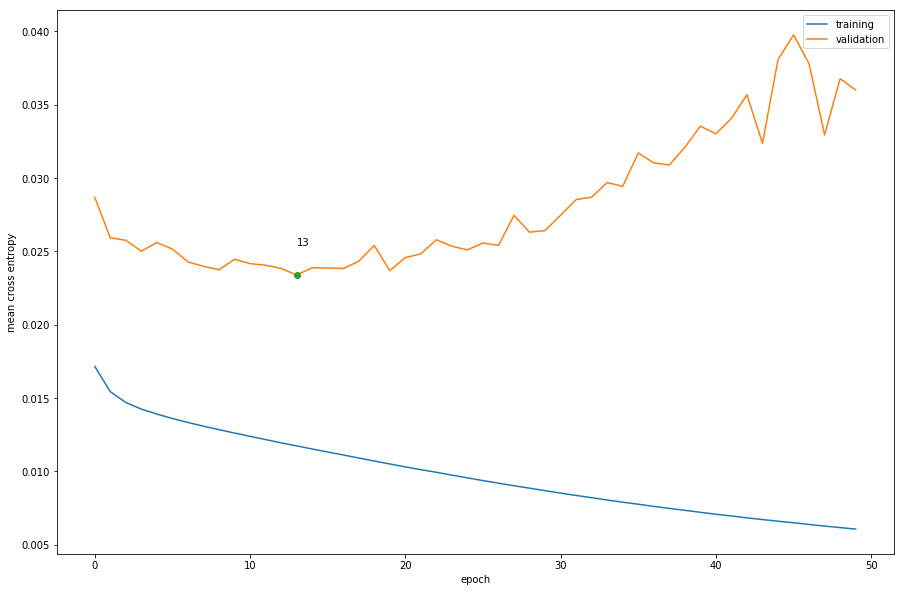

In [9]:
for r in sorted_record_list:
    if r['name'] not in selected_model:        
        continue
        
    val_min_y = min(r['val']['xen_curve'])
    val_min_x = r['val']['xen_curve'].index(val_min_y)
    print(val_min_y, r['name'])

    plt.close('all')
    plt.figure(figsize=(15,10))
    plt.plot(r['train']['xen_curve'], label='training')
    plt.plot(r['val']['xen_curve'], label='validation')
    
    plt.plot(val_min_x, val_min_y, 'o')
    plt.annotate(str(val_min_x), xy=(val_min_x, val_min_y), xytext=(val_min_x, val_min_y+0.002))
        
    plt.xlabel('epoch')
    plt.ylabel('mean cross entropy')
    
    plt.legend()
    plt.savefig(r['name'], bbox_inches='tight', transparent=True)
    plt.show()
    print()
    

In [ ]:
print("%-30s & %-6s %-6s   %-7s   %-9s | %-6s   %-6s   %-7s   %-9s \\\\ %s \n" % ('structure',
                                   'bl_acc', 'recall',  'avg_pre','train_AUC',  
                                   'bl_acc',   'recall','avg_pre','val_AUC',  
                                   'name'))
for r in sorted_record_list:
    upsample = r['pos']/64.0

    train_bal_acc = (r['train']['pos_recall'] + r['train']['neg_recall'])/2
    val_bal_acc = (r['val']['pos_recall'] + r['train']['neg_recall'])/2
    print("%-30s & %-7.3f & %-7.3f & %-4.3f & %-7.3f & %-7.3f & %-4.3f \\\\ %% %s \n" % 
          (r['conv'].replace('|', '| '), # +' '+r['cat'],
           r['train']['bal_acc'], r['train']['avg_pre'], r['train']['AUC'], 
           r['val']['bal_acc'],   r['val']['avg_pre'],   r['val']['AUC'],
           r['name'])
         )

    assert (abs(r['val']['pos_recall'] + r['val']['neg_recall'])/2 - r['val']['bal_acc']) < 1e-3
    assert (abs(r['train']['pos_recall'] + r['train']['neg_recall'])/2 - r['train']['bal_acc']) < 1e-3

In [ ]:
import re
file = open('./norm_T   up_sample   train_acc   recall   val_acc')
table = file.read()
file.close()

In [ ]:
re.sub('- .* \\\\', '\\\\', table)

In [25]:
import math
convnet     = [[3,1,1], [2,2,0], [3,1,1], [2,2,0], [3,1,1], [4,2,49], [4,2,97]]
layer_names = ['conv1', 'pool1', 'conv2', 'pool2', 'convT', 'Dconv1', 'Dconv2']
imsize = 128

def outFromIn(conv, layerIn):
    n_in = layerIn[0]
    j_in = layerIn[1]
    r_in = layerIn[2]
    start_in = layerIn[3]
    k = conv[0]
    s = conv[1]
    p = conv[2]
    
    n_out = math.floor((n_in - k + 2*p)/s) + 1
    actualP = (n_out-1)*s - n_in + k 
    pR = math.ceil(actualP/2)
    pL = math.floor(actualP/2)
    
    j_out = j_in * s
    r_out = r_in + (k - 1)*j_in
    start_out = start_in + ((k-1)/2 - pL)*j_in
    return n_out, j_out, r_out, start_out
    
def printLayer(layer, layer_name):
    print(layer_name + ":", end='\t')
    print("\t n features: %s \t jump: %s \t receptive size: %s \t start: %s " % (layer[0], layer[1], layer[2], layer[3]))

layerInfos = []


# [filter size, stride, padding]
#Assume the two dimensions are the same
#Each kernel requires the following parameters:
# - k_i: kernel size
# - s_i: stride
# - p_i: padding (if padding is uneven, right padding will higher than left padding; "SAME" option in tensorflow)
# 
#Each layer i requires the following parameters to be fully represented: 
# - n_i: number of feature (data layer has n_1 = imagesize )
# - j_i: distance (projected to image pixel distance) between center of two adjacent features
# - r_i: receptive field of a feature in layer i
# - start_i: position of the first feature's receptive field in layer i (idx start from 0, negative means the center fall into padding)


if __name__ == '__main__':
#first layer is the data layer (image) with n_0 = image size; j_0 = 1; r_0 = 1; and start_0 = 0.5
    print ("-------Net summary------")
    currentLayer = [imsize, 1, 1, 0.5]
    printLayer(currentLayer, "input")
    for i in range(len(convnet)):
        currentLayer = outFromIn(convnet[i], currentLayer)
        layerInfos.append(currentLayer)
        printLayer(currentLayer, layer_names[i])
    print ("------------------------")
#     layer_name = input ("Layer name where the feature in: ")
#     layer_idx = layer_names.index(layer_name)
#     idx_x = int(input ("index of the feature in x dimension (from 0)"))
#     idx_y = int(input ("index of the feature in y dimension (from 0)"))
    
    n = layerInfos[layer_idx][0]
    j = layerInfos[layer_idx][1]
    r = layerInfos[layer_idx][2]
    start = layerInfos[layer_idx][3]
    assert(idx_x < n)
    assert(idx_y < n)
    
    print ("receptive field: (%s, %s)" % (r, r))
    print ("center: (%s, %s)" % (start+idx_x*j, start+idx_y*j))


-------Net summary------
input:		 n features: 128 	 jump: 1 	 receptive size: 1 	 start: 0.5 
conv1:		 n features: 128 	 jump: 1 	 receptive size: 3 	 start: 0.5 
pool1:		 n features: 64 	 jump: 2 	 receptive size: 4 	 start: 1.0 
conv2:		 n features: 64 	 jump: 2 	 receptive size: 8 	 start: 1.0 
pool2:		 n features: 32 	 jump: 4 	 receptive size: 10 	 start: 2.0 
convT:		 n features: 32 	 jump: 4 	 receptive size: 18 	 start: 2.0 
Dconv1:		 n features: 64 	 jump: 8 	 receptive size: 30 	 start: -188.0 
Dconv2:		 n features: 128 	 jump: 16 	 receptive size: 54 	 start: -952.0 
------------------------
receptive field: (18, 18)
center: (2.0, 6.0)
